# SGD Picture
For this puzzle, we want to construct a dataset, such that the trajectories during training follow a pre-defined pattern. We stick to the easiest model: a linear model with a bias term and a single weight. Also, to keep it simple, we use SGD with batch-size 1, start at the origin, and set the learning rate to 1. Moreover, we will assume that training is done with a squared error loss.

In order to find the $(x, y)$-datapoints needed for this to work, we can write down the SGD updates. They are:

$$
w_1^{(i)} = w_1^{(i-1)} - 2( w_1^{(i-1)} +  w_2^{(i-1)} x - y)
$$
$$
w_2^{(i)} = w_2^{(i-1)} - 2x(w_1^{(i-1)} +  w_2^{(i-1)} x - y),
$$

where $w_1$ denotes the bias and $w_2$ the weight. We can solve this system of equations for $x$ and $y$ and obtain the formulae defined below:

In [1]:
def calculate_x(w_n: tuple[float], w_n_minus_1: tuple[float]):
    a, b = w_n_minus_1
    c, d = w_n
    if a == c:
        print(w_n, w_n_minus_1)
    return (b - d) / (a - c)

def calculate_y(w_n: tuple[float], w_n_minus_1: tuple[float]):
    a, b = w_n_minus_1
    c, d = w_n

    return (a**2 + 2 * b**2 - 2 * b * d - c ** 2) / (2 * a - 2 * c)


Let's define a toy shape, and derive the entire dataset:

In [2]:
def create_dataset(shape):
    x = [
        calculate_x(w_n, w_n_minus_1)
        for w_n, w_n_minus_1
        in zip(shape[1:], shape[:-1])
    ]
    y = [
        calculate_y(w_n, w_n_minus_1)
        for w_n, w_n_minus_1
        in zip(shape[1:], shape[:-1])
    ]
    return x, y

shape = [
    (0, 0),
    (0.5, 1),
    (1, 2),
    (0, 0),
]

x, y = create_dataset(shape)


Try it out (and initialize the weights to zero, otherwise we have no control over what will happen). We always log the weight and bias at every step.

In [3]:
import torch

model = torch.nn.Linear(1, 1)

# initialize weights at zero
torch.nn.init.zeros_(model.weight)
torch.nn.init.zeros_(model.bias)

optim = torch.optim.SGD(model.parameters(), lr=1)

trajectory = []

for x_, y_ in zip(x, y):
    trajectory.append(
        (model.bias.item(), model.weight.item())
    )

    x_tensor = torch.tensor([x_])
    y_tensor = torch.tensor(y_)

    model.zero_grad()
    prediction = model(x_tensor)
    loss = (prediction - y_tensor) ** 2
    loss.backward()
    optim.step()

trajectory


[(0.0, 0.0), (0.5, 1.0), (1.0, 2.0)]

It worked!

## Create the actual dataset: Picture of the UK

Due to lazyness, I just create a new file from the original svg only containing the polyline. We parse this file:

In [ ]:
with open("../resources/uk_polyline.txt", "r") as f:
    uk_path = f.read()

def parse_coordinates(coordinate_pair, origin):
    origin_x, origin_y = origin
    x, y = coordinate_pair.strip().split(",")
    return round(float(x) - origin_x, 1), round((-float(y) + origin_y),1 )

parsed_uk_path = [
    parse_coordinates(coordinate_pair, (575, 620))
    for coordinate_pair
    in uk_path.split(" ")
]

Let's see what it looks like:

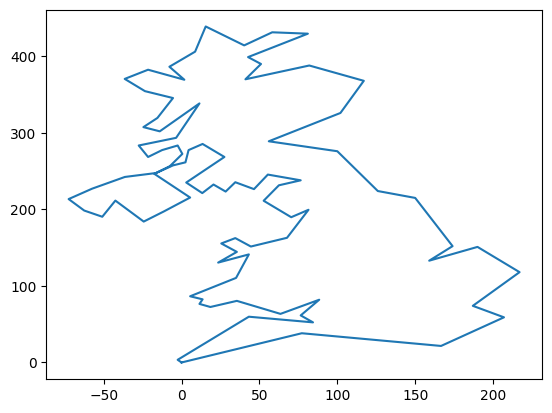

In [15]:
from matplotlib import pyplot as plt

xs, ys = zip(*parsed_uk_path)

plt.plot(xs, ys)

In [16]:
x, y = create_dataset(parsed_uk_path)

Let's try it out!

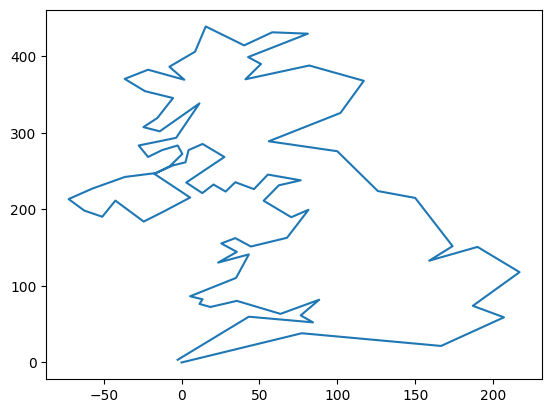

In [13]:
import torch

model = torch.nn.Linear(1, 1)

# initialize weights at zero
torch.nn.init.zeros_(model.weight)
torch.nn.init.zeros_(model.bias)

optim = torch.optim.SGD(model.parameters(), lr=1)

trajectory = []

for x_, y_ in zip(x, y):
    trajectory.append(
        (model.bias.item(), model.weight.item())
    )

    x_tensor = torch.tensor([x_])
    y_tensor = torch.tensor(y_)

    model.zero_grad()
    prediction = model(x_tensor)
    loss = (prediction - y_tensor) ** 2
    loss.backward()
    optim.step()

    # numerical instabilities make everything "blow up" after 20 iterations or so
    model.bias.data = model.bias.data.round(decimals=1)
    model.weight.data = model.weight.data.round(decimals=1)

xs, ys = zip(*trajectory)

plt.plot(xs, ys)

Unfortunately, you have to round the bias and weight after every iteration, otherwise we get numerical instabilities. But like this, it works!

In [ ]:
import pandas as pd
df = pd.DataFrame({"x": x, "y": y})
df.to_csv("../puzzle/dataset.csv", index_label="order")